# KNN implementation

In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X = pd.read_csv('xdata.csv')
Y = pd.read_csv('ydata.csv')

In [3]:
print(X.shape,Y.shape)

# change x,y from pd dataset to numpy
X = X.values
Y = Y.values

X = X[:,1:]
Y = Y[:,1:]

(399, 3) (399, 2)


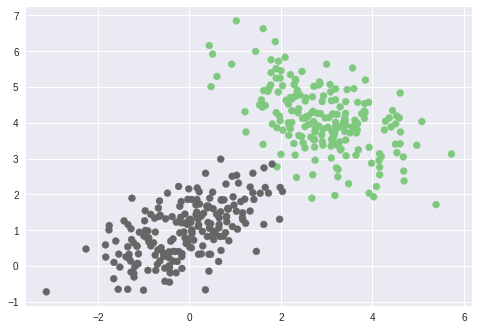

In [4]:
plt.style.use('seaborn')
plt.scatter(X[:,0],X[:,1],c=Y.reshape(-1,),cmap=plt.cm.Accent)
plt.show()

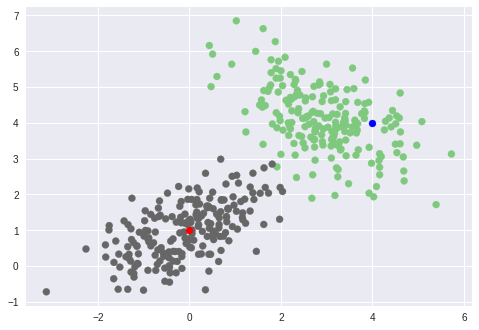

In [5]:
# check where 2,3 lies
import numpy as np
query1 = np.array([0,1])
query2 = np.array([4,4])

plt.style.use('seaborn')
plt.scatter(X[:,0],X[:,1],c=Y.reshape(-1,),cmap=plt.cm.Accent)
plt.scatter(query1[0],query1[1],color="red")
plt.scatter(query2[0],query2[1],color="blue")
plt.show()

In [79]:
def distance(qp,random_d):
    d = np.sum((qp - random_d)**2)
    return np.sqrt(d)

def knn(X,Y,qp):
    m = X.shape[0]
    dist = []
    
    for i in range(m):
        d = distance(qp,X[i])
        dist.append((d,Y[i]))
    
    dist = sorted(dist)
    
    # k best select , k is odd
    k = 7
    dist = np.array(dist)
    dist = dist[:k]
    
    
    count = np.unique(dist[:,1],return_counts=True)  # this is unique-ness
    index = count[1].argmax()
    return count[0][index]
    
    #index = dist[1].argmax()
    #return index

In [80]:
class1 = knn(X,Y,query1)
class2 = knn(X,Y,query2)

print(class1,class2)

[1.] [0.]


# FACE CLASSIFIER

In [1]:
import cv2
import numpy as np

In [2]:
cap = cv2.VideoCapture(0)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')  # loaded full face recognition

skip = 0
face_data = []
dataset_path = './data/'

file_name = input("Enter your name : ")

while True:
    ret,frame = cap.read()   # cap has captured video and return true if captured also frame
    
    if ret == False:
        continue
    
    #cv2.imshow("VIDEO FRAME",frame)
    #gray_frame = cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(frame,1.3,5)
    #gray_frame = cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)
    
    faces = sorted(faces,key = lambda f:f[2]*f[3]) # where 2,3 are the index of tuple having x(0),y(1),w(2),h(3) so max area is h*w that's why f[2]*f[3] as we have to take max area face
    
    for i in faces[-1:]:
        x,y,w,h = i
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,255,255),3)
       
        offset = 10    # similar to padding 
        face_section = frame[y-offset:y+h+offset,x-offset:x+w+offset]
    
        face_section = cv2.resize(face_section,(100,100))
    
        skip += 1
        if skip%10 == 0:
            face_data.append(face_section)
            print(len(face_data))
    
    cv2.imshow("FRAME",frame)
    #cv2.imshow("Face Section",face_section)

    # after every 1 millisecond it expects key input else refreshes current frame 
    key = cv2.waitKey(1)&0xFF
    if key == ord('q'):
        break

        
# save file
face_data = np.asarray(face_data)
face_data = face_data.reshape((face_data).shape[0],-1)

np.save(dataset_path + file_name + '.npy' ,face_data)
print("DATA successfully saved!" + dataset_path + file_name + '.npy')

cap.release()
cv2.destroyAllWindows()


Enter your name : shubh
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
DATA successfully saved!./data/shubh.npy


In [1]:
# Building Face Classifier

import os
import numpy as np
import cv2

In [ ]:
dataset_path = './data/'

faces_data = []    # as a dataset
labels = []        # as labels kiske similar jyada hai n ol

curr_id = 0
names = {}

cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

for fx in os.listdir(dataset_path):
    if fx.endswith('.npy'):
        
        names[curr_id] = fx[:-4]
        print("LOADED "+fx)
        data_items = np.load(dataset_path+fx)
        faces_data.append(data_items)
        
        class_id = curr_id*np.ones((data_items.shape[0],))
        labels.append(class_id)
        curr_id += 1

# concatenating just because knn requires matrix with features and labels

face_dataset = np.concatenate(faces_data,axis=0)
labels_dataset = np.concatenate(labels,axis=0).reshape(-1,1)

#print(face_dataset.shape,labels_dataset.shape)


trainset = np.concatenate((face_dataset,labels_dataset),axis=1)

def distance(qp,random_d):
    d = np.sum((qp - random_d)**2)
    return np.sqrt(d)

def knn(X,Y,qp):
    m = X.shape[0]
    dist = []
    
    for i in range(m):
        d = distance(qp,X[i])
        dist.append((d,Y[i]))
    
    dist = sorted(dist)
    
    # k best select , k is odd
    k = 7
    dist = np.array(dist)
    dist = dist[:k]
    
    
    count = np.unique(dist[:,1],return_counts=True)  # this is unique-ness
    index = count[1].argmax()
    return count[0][index]


while True:
    ret,frame = cap.read()
    
    if ret == False:
        continue
    
    faces = face_cascade.detectMultiScale(frame,1.3,5)
    
    # ROI
    for face in faces:
        offset = 10
        # crop and then compare
        face_section = faces[y-offset:y+h+offset,x-offset:x+w+offset]
        
        # now compare this face with saved ones
        out = knn(trainset[:,:-1],trainset[:,-1],face_section.flatten())
        
        pred_name = names[int(out)]
        
        cv2.putText(frame,pred_name,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),cv2.LINE_AA)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)
        
        cv2.imshow("FACES",frame)
        
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()    

LOADED shubh.npy
LOADED shubhkumar.npy


In [ ]:
cap.release()
cv2.destroyAllWindows()